In [1]:
from tensorflow.keras.applications import ResNet50, DenseNet121, densenet, VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, RandomFlip, RandomRotation, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


In [2]:
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [4]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [4]:
# Preprocess the data
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0
# y_train = to_categorical(y_train, 10)
# y_test = to_categorical(y_test, 10)

In [5]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [6]:
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [7]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [8]:
train_generator = ImageDataGenerator(
                                    rotation_range=2,
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2,
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2,
                                    horizontal_flip= True,
                                    zoom_range=.1)

In [9]:
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [10]:
lrr= ReduceLROnPlateau(
                       monitor='val_accuracy', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate

In [10]:
'The first base model used is VGG19. The pretrained weights from the imagenet challenge are used'
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

'For the 2nd base model we will use Resnet 50 and compare the performance against the previous one.The hypothesis is that Resnet 50 should perform better because of its deeper architecture'
# base_model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

80134624/80134624 [==============================] - 1s 0us/step


'For the 2nd base model we will use Resnet 50 and compare the performance against the previous one.The hypothesis is that Resnet 50 should perform better because of its deeper architecture'

In [11]:
model_1= Sequential()
model_1.add(base_model_1) #Adds the base model (in this case vgg19 to model_1)
model_1.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers

In [12]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
Total params: 20024384 (76.39 MB)
Trainable params: 20024384 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
#Add the Dense layers along with activation and batch normalization
model_1.add(Dense(1024,activation=('relu'),input_dim=512))
model_1.add(Dense(512,activation=('relu')))
model_1.add(Dense(256,activation=('relu')))
#model_1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_1.add(Dense(128,activation=('relu')))
#model_1.add(Dropout(.2))
model_1.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [14]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 10)                1

In [16]:
batch_size= 100
epochs=25

In [15]:
learn_rate=.001

sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

In [17]:
#Compile the model
#During model compiling the 3 main things we specify are loss function,optimizer and the metrics that need to be evaluated during the test and train processes.
#Lets start by using the SGD optimizer
#We will specify the loss as categoricl crossentropy since the labels are 1 hot encoded. IF we had integer labels,we'd have to use sparse categorical crossentropy as loss function.
model_1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
# model_1.fit(train_generator.flow(x_train,y_train,batch_size=batch_size),
#                       epochs=epochs,
#                       steps_per_epoch=x_train.shape[0]//batch_size,
#                       validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
#                       callbacks=[lrr],verbose=1)

model_1.fit(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
                      verbose=1)

Epoch 1/25
350/350 [==============================] - ETA: 0s - loss: 2.2170 - accuracy: 0.1718

350/350 [==============================] - 44s 99ms/step - loss: 2.2170 - accuracy: 0.1718 - val_loss: 1.8157 - val_accuracy: 0.3005
Epoch 2/25
350/350 [==============================] - 27s 78ms/step - loss: 1.3350 - accuracy: 0.5090
Epoch 3/25
350/350 [==============================] - 26s 73ms/step - loss: 0.8690 - accuracy: 0.7000
Epoch 4/25
350/350 [==============================] - 25s 72ms/step - loss: 0.7041 - accuracy: 0.7593
Epoch 5/25
350/350 [==============================] - 26s 74ms/step - loss: 0.6056 - accuracy: 0.7933
Epoch 6/25
350/350 [==============================] - 25s 73ms/step - loss: 0.5296 - accuracy: 0.8172
Epoch 7/25
350/350 [==============================] - 25s 72ms/step - loss: 0.4764 - accuracy: 0.8347
Epoch 8/25
350/350 [==============================] - 25s 72ms/step - loss: 0.4243 - accuracy: 0.8530
Epoch 9/25
350/350 [==============================] - 25s 72ms/step - loss: 0.3864 - accuracy: 0.8671
Epoch 10/25
350/350 [==============================

KeyboardInterrupt: ignored

In [19]:
model_1.history.history

{'loss': [2.2170166969299316,
  1.335030198097229,
  0.8690280318260193,
  0.7041261196136475,
  0.6056238412857056,
  0.5295697450637817,
  0.4764229357242584,
  0.42432042956352234,
  0.3864438235759735,
  0.35126015543937683],
 'accuracy': [0.17177142202854156,
  0.5090000033378601,
  0.7000285983085632,
  0.7593428492546082,
  0.7933428287506104,
  0.8171714544296265,
  0.8347428441047668,
  0.8530285954475403,
  0.8670856952667236,
  0.8773142695426941],
 'val_loss': [1.815703272819519],
 'val_accuracy': [0.3004666566848755]}

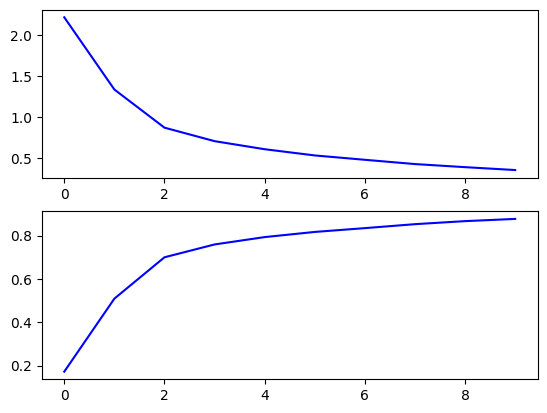

In [20]:
#Plot the training and valiation loss
'''The output of model.fit is a model.History object which is a record of metrics at each epoch. This can be used to graph the training and validation accuracy
to see where they plateaued off and if overfitting can subsequently be avoided'''

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(model_1.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model_1.history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(model_1.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model_1.history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [21]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [22]:
y_pred=model_1.predict(x_test)
y_true=np.argmax(y_test,axis=1)

#Compute the confusion matrix
# confusion_mtx=confusion_matrix(y_true,y_pred)

y_pred_classes = np.argmax(y_pred, axis=1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
confusion_mtx

313/313 [==============================] - 4s 10ms/step


array([[874,  10,  30,   5,  29,   1,   6,  10,  33,   2],
       [ 18, 917,   4,   1,   3,   1,   4,   0,  28,  24],
       [ 34,   0, 826,  12,  56,  16,  39,  13,   3,   1],
       [ 19,   4,  88, 496,  82, 162,  85,  50,  11,   3],
       [  3,   1,  40,   8, 875,   3,  34,  35,   1,   0],
       [  5,   0,  69,  65,  53, 698,  39,  69,   2,   0],
       [  3,   4,  33,  13,  19,   3, 910,   5,   8,   2],
       [  8,   1,  20,   8,  50,  15,   4, 893,   0,   1],
       [ 42,  10,   8,   4,   5,   2,   3,   0, 920,   6],
       [ 52,  88,   5,  11,   5,   4,   3,  15,  16, 801]])

In [23]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Confusion matrix, without normalization


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

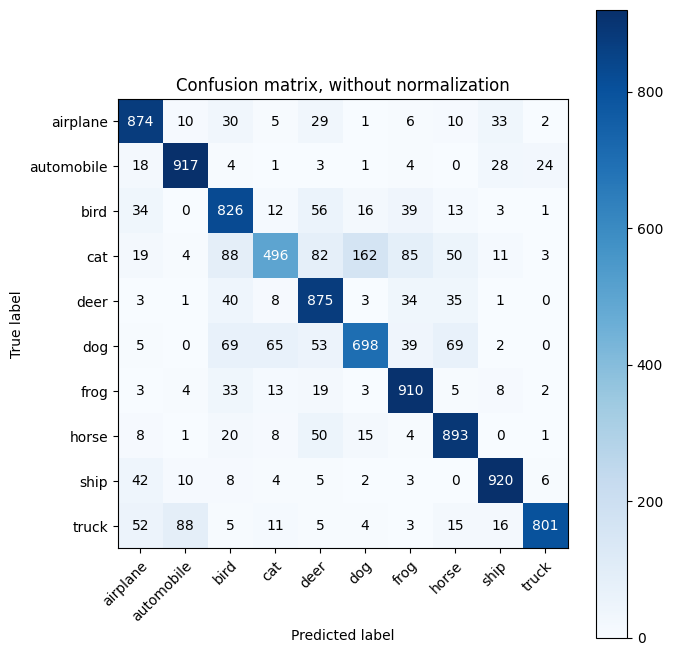

In [24]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

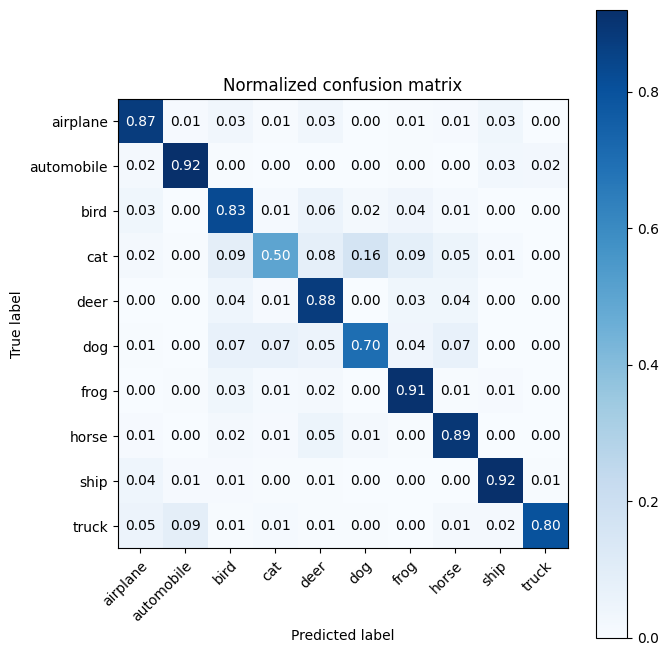

In [25]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
# plt.show()

In [27]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [28]:
print((x_train.shape,y_train.shape))
print((x_test.shape,y_test.shape))

((50000, 32, 32, 3), (50000, 1))
((10000, 32, 32, 3), (10000, 1))


In [29]:
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [30]:
print((x_train.shape,y_train.shape))
print((x_test.shape,y_test.shape))

((50000, 32, 32, 3), (50000, 10))
((10000, 32, 32, 3), (10000, 10))


In [31]:
X_train = x_train.astype('float32') / 255.0
X_test = x_test.astype('float32') / 255.0

In [32]:
print(X_train.shape)
print(X_train[0].shape)
print(X_train[1:].shape)

(50000, 32, 32, 3)
(32, 32, 3)
(49999, 32, 32, 3)


In [4]:
# Load the ResNet50 model with pre-trained weights on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

94765736/94765736 [==============================] - 5s 0us/step


In [71]:
dense_model = DenseNet121(input_shape=x_train[0].shape, include_top=False, weights='imagenet')

29084464/29084464 [==============================] - 0s 0us/step


In [74]:
intermediate_layer = 'conv2_block6_0_relu'
modified_model = Model(inputs=dense_model.input, outputs=dense_model.get_layer(intermediate_layer).output)

In [75]:


# Freeze the convolutional layers
dense_model.trainable = False

# Data augmentation
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
])

# Preprocess input and create the model
preprocess_input = densenet.preprocess_input
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(10, activation='softmax')  # Assuming you have 10 classes for CIFAR-10

# Build the model
inputs = Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = dense_model(x, training=False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)

model = Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model
score = model.evaluate(x_test, y_test)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

Epoch 1/10
1563/1563 [==============================] - 41s 21ms/step - loss: 2.3099 - accuracy: 0.2952 - val_loss: 1.4855 - val_accuracy: 0.4785
Epoch 2/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.6709 - accuracy: 0.4373 - val_loss: 1.2842 - val_accuracy: 0.5492
Epoch 3/10
1563/1563 [==============================] - 29s 19ms/step - loss: 1.5052 - accuracy: 0.4823 - val_loss: 1.2067 - val_accuracy: 0.5749
Epoch 4/10
1563/1563 [==============================] - 29s 18ms/step - loss: 1.4211 - accuracy: 0.5052 - val_loss: 1.1519 - val_accuracy: 0.5951
Epoch 5/10
1563/1563 [==============================] - 30s 19ms/step - loss: 1.3588 - accuracy: 0.5227 - val_loss: 1.1258 - val_accuracy: 0.6059
Epoch 6/10
1563/1563 [==============================] - 32s 20ms/step - loss: 1.3318 - accuracy: 0.5313 - val_loss: 1.1078 - val_accuracy: 0.6122
Epoch 7/10
1563/1563 [==============================] - 41s 26ms/step - loss: 1.2988 - accuracy: 0.5422 - val_loss: 1.0935 -

In [76]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 32, 32, 3)         0         
 a)                                                              
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 32, 32, 3)         0         
 )                                                               
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 32, 32, 3)         0         
 bda)                                                            
                                                           

In [77]:
len(model.trainable_variables)

2

In [79]:
# Decide which layers to freeze/unfreeze
# Freeze the convolutional layers up to a certain point
freeze_until_layer = 'conv5_block2_out'
for layer in dense_model.layers:
    layer.trainable = False
    if layer.name == freeze_until_layer:
        break


In [80]:
# Create a new model
model = Sequential()
model.add(dense_model)
model.add(Flatten())
model.add(Dense(256, activation='relu', input_dim=512))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
# Train the model
history_transfer_learning = model.fit(x_train, y_train, epochs=10, batch_size=100, validation_data=(x_test, y_test))

Epoch 1/10
500/500 [==============================] - 20s 24ms/step - loss: 1.9530 - accuracy: 0.3807 - val_loss: 1.4522 - val_accuracy: 0.4732
Epoch 2/10
500/500 [==============================] - 9s 18ms/step - loss: 1.4810 - accuracy: 0.4714 - val_loss: 1.3691 - val_accuracy: 0.5130
Epoch 3/10
500/500 [==============================] - 9s 18ms/step - loss: 1.4035 - accuracy: 0.5009 - val_loss: 1.3358 - val_accuracy: 0.5214
Epoch 4/10
500/500 [==============================] - 10s 19ms/step - loss: 1.3653 - accuracy: 0.5193 - val_loss: 1.2832 - val_accuracy: 0.5443
Epoch 5/10
500/500 [==============================] - 11s 22ms/step - loss: 1.3379 - accuracy: 0.5277 - val_loss: 1.3160 - val_accuracy: 0.5365
Epoch 6/10
500/500 [==============================] - 10s 19ms/step - loss: 1.3137 - accuracy: 0.5355 - val_loss: 1.2765 - val_accuracy: 0.5454
Epoch 7/10
500/500 [==============================] - 10s 20ms/step - loss: 1.2948 - accuracy: 0.5415 - val_loss: 1.2901 - val_accuracy: 0

In [82]:
# Evaluate the transfer learning model
score_transfer_learning = model.evaluate(x_test, y_test)
print(f'Transfer Learning - Test loss: {score_transfer_learning[0]}, Test accuracy: {score_transfer_learning[1]}')

313/313 [==============================] - 7s 15ms/step - loss: 1.2583 - accuracy: 0.5550
Transfer Learning - Test loss: 1.258304238319397, Test accuracy: 0.5550000071525574


In [39]:
# Create a new model for training from scratch
model_scratch = Sequential()
model_scratch.add(Flatten(input_shape=(32, 32, 3)))
model_scratch.add(Dense(256, activation='relu', input_dim=512))
model_scratch.add(Dropout(0.2))
model_scratch.add(Dense(512, activation='relu'))
model_scratch.add(Dropout(0.2))
model_scratch.add(Dense(1024, activation='relu'))
model_scratch.add(Dropout(0.2))
model_scratch.add(Dense(512, activation='relu'))
model_scratch.add(Dropout(0.2))
model_scratch.add(Dense(256, activation='relu'))
model_scratch.add(Dropout(0.2))
model_scratch.add(Dense(10, activation='softmax'))


In [40]:
# Compile the model
model_scratch.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
# Train the model from scratch
history_scratch = model_scratch.fit(x_train, y_train, epochs=25, batch_size=100, validation_data=(x_test, y_test))

Epoch 1/25
500/500 [==============================] - 4s 5ms/step - loss: 4.0243 - accuracy: 0.1007 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/25
500/500 [==============================] - 3s 6ms/step - loss: 2.3028 - accuracy: 0.0989 - val_loss: 2.3030 - val_accuracy: 0.0998
Epoch 3/25
500/500 [==============================] - 2s 5ms/step - loss: 2.3029 - accuracy: 0.0988 - val_loss: 2.3030 - val_accuracy: 0.0999
Epoch 4/25
500/500 [==============================] - 2s 4ms/step - loss: 2.3030 - accuracy: 0.0983 - val_loss: 2.3026 - val_accuracy: 0.1002
Epoch 5/25
500/500 [==============================] - 2s 5ms/step - loss: 2.3030 - accuracy: 0.0976 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 6/25
500/500 [==============================] - 2s 4ms/step - loss: 2.3030 - accuracy: 0.0988 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 7/25
500/500 [==============================] - 3s 5ms/step - loss: 2.3029 - accuracy: 0.0987 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 

In [42]:
# Evaluate the model trained from scratch
score_scratch = model_scratch.evaluate(x_test, y_test)
print(f'Training from Scratch - Test loss: {score_scratch[0]}, Test accuracy: {score_scratch[1]}')

313/313 [==============================] - 1s 4ms/step - loss: 2.3029 - accuracy: 0.1000
Training from Scratch - Test loss: 2.3028764724731445, Test accuracy: 0.10000000149011612


In [43]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [44]:
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(256, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output and feed it into dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

In [45]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 21s 12ms/step - loss: 2.0366 - accuracy: 0.4542 - val_loss: 1.2234 - val_accuracy: 0.5661
Epoch 2/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1.2414 - accuracy: 0.5684 - val_loss: 1.1725 - val_accuracy: 0.5945
Epoch 3/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1.1076 - accuracy: 0.6180 - val_loss: 1.1013 - val_accuracy: 0.6246
Epoch 4/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.9908 - accuracy: 0.6588 - val_loss: 1.0255 - val_accuracy: 0.6514
Epoch 5/10
1563/1563 [==============================] - 18s 12ms/step - loss: 0.9092 - accuracy: 0.6871 - val_loss: 1.0531 - val_accuracy: 0.6419
Epoch 6/10
1563/1563 [==============================] - 18s 12ms/step - loss: 0.8152 - accuracy: 0.7204 - val_loss: 1.0560 - val_accuracy: 0.6583
Epoch 7/10
1563/1563 [==============================] - 18s 12ms/step - loss: 0.7355 - accuracy: 0.7472 - val_loss: 1.1094 -

In [46]:
# Evaluate the model
score = model.evaluate(x_test, y_test)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

313/313 [==============================] - 1s 4ms/step - loss: 1.3514 - accuracy: 0.6562
Test loss: 1.3513758182525635
Test accuracy: 0.6561999917030334
